In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from utilities import Mapping
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import re

# Synergy Score

## 1. Load Data

In [3]:
summary = pd.read_csv('summary_v_1_5.csv')

C:\Users\deshen wang\AppData\Local\Temp\ipykernel_12000\1638046646.py:1: DtypeWarning: Columns (2,7,19,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  summary = pd.read_csv('summary_v_1_5.csv')


In [4]:
print(f"There are {summary['study_name'].nunique()} unique values in the 'study_name' column, they are {summary['study_name'].unique()}. ")

There are 34 unique values in the 'study_name' column, they are ['GDSC1' 'CTRPV2' 'CCLE' 'GCSI' 'NCATS_ES(FAKI/AURKI)'
 'NCATS_ES(NAMPT+PARP)' 'NCATS_DIPG' 'GRAY' 'FIMM' 'ALMANAC' 'FLOBAK'
 'FORCINA' 'YOHE' 'NCATS_HL' 'WILSON' 'ASTRAZENECA' 'SCHMIDT' 'UHNBREAST'
 'ONEIL' 'NCATS_MDR_CS' 'CLOUD' 'PHELAN' 'MATHEWS' 'NCATS_ATL' 'BEATAML'
 'NCATS_2D_3D' 'NCATS_SARS-COV-2DPI' 'BOBROWSKI' 'DYALL' 'MOTT' 'FRIEDMAN'
 'FALLAHI-SICHANI' 'FRIEDMAN2' 'MILLER']. 


In [5]:
# Create a mapping from study_name to a unique number for study_id
study_name_to_id = {name: idx for idx, name in enumerate(summary['study_name'].unique(), start=1)}

# Apply the mapping to the 'study_name' column to create a new 'study_id' column
summary['study_id'] = summary['study_name'].map(study_name_to_id)

In [6]:
columns_to_drop = ['drug_col_target_name', 'drug_row_target_name', 'drug_col_clinical_phase', 'drug_row_clinical_phase', 'study_name','tissue_name', 'conc_row_unit','conc_col_unit'] 
summary_study = summary.drop(columns=columns_to_drop).dropna()
summary_study['synergy_loewe'] = pd.to_numeric(summary_study['synergy_loewe'], errors='coerce')

In [7]:
summary_mean = summary_study.groupby(['drug_row','drug_col','cell_line_name', 'study_id'], as_index=False).mean()
summary_mean = summary_mean.loc[:, ['drug_row', 'drug_col', 'cell_line_name', 'study_id','ri_row', 'ri_col', 'synergy_loewe']]

In [8]:
codes={'drugs': Mapping(set(summary_mean['drug_row'].unique()).union(set(summary_mean['drug_col'].unique()))),
      'cell':Mapping(summary_mean['cell_line_name'].unique())}

In [9]:
summary_mean['drug_col']=summary_mean['drug_col'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['drug_row']=summary_mean['drug_row'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['cell_line_name']=summary_mean['cell_line_name'].apply(lambda x: codes['cell'].item2idx[x])

In [10]:
summary_mean.to_pickle('summary_mean.p')

In [11]:
summary_mean.head()

,drug_row,drug_col,cell_line_name,study_id,ri_row,ri_col,synergy_loewe
0,2423,3158,0,12,-21.079400,17.392589,4.436431
1,1103,3920,1,23,-20.043000,25.595000,-44.555935
2,1103,2218,1,23,-9.776000,29.111000,-37.189720
3,339,3158,0,12,-4.051616,17.392589,10.755529
4,1596,4134,2,5,1.966000,25.537000,-8.644502


# Drug's Molescule Structure

In [12]:
# read drug Excel file into a DataFrame
drug = pd.read_excel('dump/drug2.xlsx', engine='openpyxl')

In [13]:
#drop unnamed column
drug = drug.drop(columns=['Unnamed: 0'])
drug = drug.rename(columns={'pubchem_cid': 'cid'})

In [14]:
# updating the 'id' column in the drug 
drug['id'] = drug['name'].apply(lambda x: codes['drugs'].item2idx.get(x))
# filters out rows where the 'id' has missing values 
drug = drug.loc[~drug['id'].isna(),:]

In [15]:
print(drug['smiles'].isna().any())

False


In [16]:
drug['fps'] = drug['smiles'].apply(lambda x: list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x))) if Chem.MolFromSmiles(x) is not None else '')
drug['id']=drug['id'].apply(lambda x: int(x))

In [17]:
#Convert SMILES's character into index
seqs = drug['smiles'].to_list()
chars = set([char for seq in seqs for char in seq])
chars = [''] + list(chars) #for zero embedding
codes['mole'] = Mapping(chars)
drug['smiles'] = drug['smiles'].apply(lambda x : [codes['mole'].item2idx[char] for char in x])

# Drug's target gene

In [30]:
#Load DrugBank target into a pandas dataframe
drug_DrugBank_target=pd.read_csv('drug/drug_DrugBank_target.csv')
drug_DrugBank_target.head()

,Gene,uniprot_protein_acc_id,drugbank_id,drug_name,drug_action_type,drug_status,drug_status2
0,F2,P00734,DB00001,Lepirudin,Inhibitor,Biotech,Approved
1,EGFR,P00533,DB00002,Cetuximab,Antagonist,Biotech,Approved
2,ERBB,P00533,DB00002,Cetuximab,Antagonist,Biotech,Approved
3,ERBB1,P00533,DB00002,Cetuximab,Antagonist,Biotech,Approved
4,HER1,P00533,DB00002,Cetuximab,Antagonist,Biotech,Approved


In [31]:
#group the data by drugbank_id, then convert 'Gene' to a list.
drug_DrugBank_target =  (
    drug_DrugBank_target.groupby('drugbank_id')['Gene']
    .agg(lambda x: list(set().union(*x)))
    .reset_index()
)
drug_DrugBank_target.head()

,drugbank_id,Gene
0,DB00001,"[F, 2]"
1,DB00002,"[E, S, F, D, Q, G, H, A, I, R, 1, C, 3, 6, B, 2]"
2,DB00004,"[A, G, I, R, 1, 2, L, B, 5]"
3,DB00005,"[T, S, F, D, N, Q, A, G, I, R, 1, C, 2, 3, B, ..."
4,DB00006,"[F, 2]"


In [32]:
drug = pd.merge(drug, drug_DrugBank_target, how='left', on='drugbank_id')

In [33]:
drug.rename(columns={'Gene':'gene_drugbank'}, inplace=True)

In [34]:
drug['gene_drugbank'] = drug['gene_drugbank'].apply(lambda x: [] if type(x) is float else x)

Merge target genes from TTD

In [35]:
drug_TTD_target = pd.read_csv('drug/drug_TTD_target.csv')
drug_TTD_target['TTD_TARGETS'] = drug_TTD_target['TTD_TARGETS'].apply(lambda x: re.split(',|;', x))
drug = pd.merge(drug, drug_TTD_target.loc[:,['TTD_TARGETS', 'cid']],how='left', on='cid')
drug.rename(columns={'TTD_TARGETS':'gene_ttd'}, inplace=True)
drug['gene_ttd'] = drug['gene_ttd'].apply(lambda x: [] if type(x) is float else x)

Merge target genes from LINC

In [36]:
drug_lincs_target = pd.read_csv('drug/drug_lincs_target.csv')
drug_lincs_target['target_genes']=drug_lincs_target['target_genes'].apply(lambda x: x.split(',') if type(x) is not float else [])
drug = pd.merge(drug, drug_lincs_target.loc[:, ['target_genes', 'cid']], how='left', on='cid')
drug.rename(columns={'target_genes':'gene_linc'}, inplace=True)

Combine target genes 

In [37]:
drug['gene'] = drug.apply(lambda row: list(set(row['gene_drugbank']+row['gene_ttd']+row['gene_linc'])), axis=1)
unique_genes_drug = [l for lst in drug['gene'].aggregate(list).values for l in lst]

C:\Users\deshen wang\AppData\Local\Temp\ipykernel_12000\2102269707.py:2: FutureWarning: using <class 'list'> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  unique_genes_drug = [l for lst in drug['gene'].aggregate(list).values for l in lst]


## Cell Line Features

In [38]:
cell_line = pd.read_csv('cell/cell_line_meta.csv')
cell_line.drop('id',axis=1, inplace=True)

In [39]:
cell_line['cell_id'] = cell_line['name'].apply(lambda x: codes['cell'].item2idx.get(x))
cell_line.head()

,name,synonyms,cellosaurus_accession,SANGAR_ID,COSMIC_ID,BROAD_ID,CCLE_ID,tissue,disease_id,cell_id
0,786-0,786-0; 786O; 786-0; 786.O; 786-O RCC; RCC 786-...,CVCL_1051,SIDM00125,905947,ACH-000649,786O_KIDNEY,kidney,C9385,105.0
1,A2058,A2058; A 2058; A-2058,CVCL_1059,SIDM00797,906792,ACH-000788,A2058_SKIN,skin,C3802,12.0
2,A2780,A2780; A-2780; 2780; A2780S,CVCL_0134,SIDM00210,906804,ACH-000657,A2780_OVARY,ovary,C7979,211.0
3,A375,A375; A 375; A375; A375-MEL; A375-mel; A375mel,CVCL_0132,SIDM00795,906793,ACH-000219,A375_SKIN,skin,C3802,84.0
4,A427,A427; A427,CVCL_1055,SIDM00810,910851,ACH-000757,A427_LUNG,lung,C3512,212.0


In [40]:
cell_line_tissue = cell_line.loc[~cell_line['cell_id'].isna(), ['cell_id', 'tissue', 'disease_id']]
cell_line_tissue['cell_id'] = cell_line_tissue['cell_id'].astype(int)
cell_line_tissue = cell_line_tissue.groupby('cell_id').first()

In [41]:
codes['tissue'] = Mapping(cell_line_tissue['tissue'].unique())
cell_line_tissue['tissue'] = cell_line_tissue['tissue'].apply(lambda x: codes['tissue'].item2idx[x])
cell_line_tissue.rename(columns={'tissue':'tissue_id'}, inplace=True)
cell_line_tissue

,tissue_id,disease_id
cell_id,,
0,0,C3058
1,1,C8851
2,2,C4817
3,1,C9357
4,0,C94764
...,...,...
267,13,C4912
270,6,C4004
280,16,C9120


In [42]:
codes['disease'] = Mapping(cell_line_tissue['disease_id'].apply(lambda x: x.split(' ')[-1].lower() if type(x) is not float else '').unique())
cell_line_tissue['disease_id'] = cell_line_tissue['disease_id'].apply(lambda x: codes['disease'].item2idx[x.split(' ')[-1].lower()] if type(x) is not float else codes['disease'].item2idx[''])


In [43]:
codes['tissue'].item2idx['haematopoietic_and_lymphoid']=1
codes['tissue'].idx2item[1]='hem&lymp'

In [44]:
codes['tissue'].item2idx
codes['disease'].item2idx

{'c3058': 0,
 'c8851': 1,
 'c4817': 2,
 'c9357': 3,
 'c94764': 4,
 'c3716': 5,
 'c3510': 6,
 'c3224': 7,
 'c3802': 8,
 'c3174': 9,
 'c4194': 10,
 'c5214': 11,
 'c4872': 12,
 'c4017': 13,
 'c4001': 14,
 'c9385': 15,
 'c4004': 16,
 'c4349': 17,
 'c4863': 18,
 'c8971': 19,
 'c4910': 20,
 'c5543': 21,
 'c9383': 22,
 'c3512': 23,
 'c6975': 24,
 'c4033': 25,
 'c7953': 26,
 'c2926': 27,
 'c9154': 28,
 'c7979': 29,
 'c9142': 30,
 'c3493': 31,
 'c2923': 32,
 'c4450': 33,
 'c105555': 34,
 'c3242': 35,
 'c60781': 36,
 'c3796': 37,
 'c7978': 38,
 'c7873': 39,
 'c40359': 40,
 'c4912': 41,
 'c7899': 42,
 'c4917': 43,
 'c3099': 44,
 'c40078': 45,
 'c9351': 46,
 'c7700': 47,
 'c4908': 48,
 'c27677': 49,
 'c2993': 50,
 'c9120': 51}

Text(0, 0.5, 'number of cell lines')

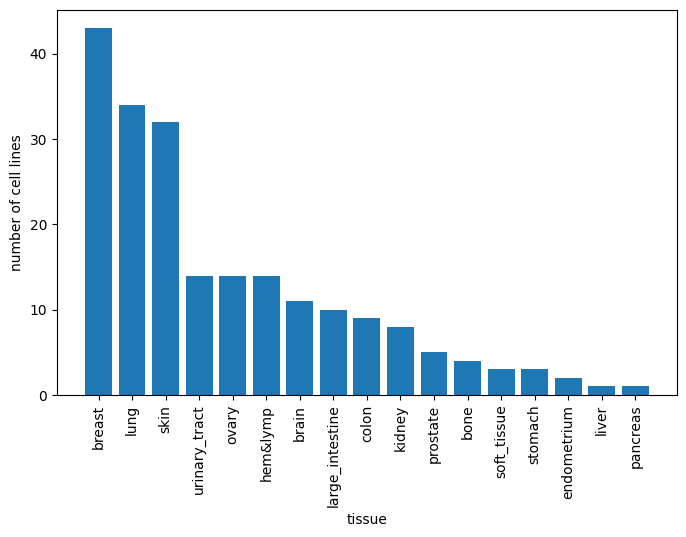

In [45]:
#Counting number of cell lines per tissue
tissue_cell_cnts=cell_line_tissue.groupby('tissue_id').count().sort_values(by='disease_id', ascending=False)['disease_id']
plt.figure(figsize=(8,5))
plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_cell_cnts.index], tissue_cell_cnts)
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of cell lines')
#plt.savefig(data_path+'tissue_num_cell.png', bbox_inches='tight', dpi=200)

# Cell line's gene expression

In [46]:
#Mapping
gene_identifiers = pd.read_csv('cell/gene_identifiers_latest.csv')
cell_line_meta = pd.read_csv('cell/cell_line_meta.csv')

_codes = {}
_codes['gene_id2hgnc_symbol'] = gene_identifiers[['gene_id', 'hgnc_symbol']].set_index('gene_id').to_dict('index')
_codes['SANGAR_ID2cell_name'] = cell_line_meta.loc[cell_line_meta['name'].isin(codes['cell'].idx2item) & ~cell_line_meta['SANGAR_ID'].isna(), ['SANGAR_ID', 'name']].set_index('SANGAR_ID').to_dict('index')

In [47]:
fpkm_broad = pd.read_csv('cell/fpkm_broad.csv')

fpkm_broad = fpkm_broad.loc[fpkm_broad['model_id'].isin(_codes['SANGAR_ID2cell_name'])] #apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_broad['model_id'] = fpkm_broad['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_broad.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_broad.columns[1:]}, inplace=True)

fpkm_broad.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_broad.set_index('cell_id', inplace=True)

In [48]:
(fpkm_broad.sum()>0).sum()

23573

In [49]:
#Sangar
fpkm_sangar = pd.read_csv('cell/fpkm_sangar.csv')

fpkm_sangar = fpkm_sangar.loc[fpkm_sangar['model_id'].isin(_codes['SANGAR_ID2cell_name'])] #apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_sangar['model_id'] = fpkm_sangar['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_sangar.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_sangar.columns[1:]}, inplace=True)

fpkm_sangar.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_sangar.set_index('cell_id', inplace=True)

In [50]:
(fpkm_sangar.sum()>0).sum()

19446

In [51]:
cell_gene_fpkm = pd.concat([fpkm_broad,fpkm_sangar], sort=True) #integrate BROAD and SANGAR
cell_gene_fpkm = cell_gene_fpkm.loc[:,(cell_gene_fpkm.std(skipna=True)!=0)] #drop genes with std=0
cell_gene_fpkm.fillna(0, inplace=True)

cell_gene_fpkm_norm = ((cell_gene_fpkm-cell_gene_fpkm.mean())/cell_gene_fpkm.std()) #z-score, gene-wise

unique_genes_cell = cell_gene_fpkm_norm.columns.to_list()

In [52]:
len(unique_genes_cell)

24268

# Integrate all genes and save pickles

In [53]:
codes['gene'] = Mapping(set(unique_genes_cell).union(set(unique_genes_drug)))


In [54]:
#number of unique genes
len(codes['gene'].idx2item)

24269

In [147]:
#Update drug's genes
drug['gene_id'] = drug['gene'].apply(lambda genes: [codes['gene'].item2idx[gene] for gene in genes])
#subset of drug features
drug[['id', 'smiles', 'fps', 'gene_id']].groupby('id').first().to_pickle('drug_features.p')

In [148]:
#Merge cell line's tissue, disease type with gene_id
cell_gene = cell_gene_fpkm_norm.apply(lambda row: {codes['gene'].item2idx[gene]:row[gene] for gene in cell_gene_fpkm_norm.columns}, axis=1).reset_index()
cell_gene.rename(columns={0:'gene_id'}, inplace=True)
cell_gene = cell_gene.groupby('cell_id').first()
cell_line = pd.merge(cell_line_tissue, cell_gene, how='left', on='cell_id')
cell_line['gene_id']=cell_line['gene_id'].apply(lambda x: {} if type(x) is float else x)

cell_line.to_pickle('cell_features.p')

In [152]:
pickle.dump(codes, open('codes.p', 'wb'))